

## Keyword Spotting (KWS)
- **Total Audios**: 20 KW x 20 SP/KW = 400 audios

## Speaker Identification (SI)
- **Total Audios**: 20 SP x 20 KW/SP = 400 audios

## Audio Name Format: `SSSKKK`
- **SSS** → Speaker ID
- **KKK** → Keyword ID
- **Format**: `.wav`

---

## Keywords - 20 Total

1. Turn on
2. Turn off
3. Increase
4. Decrease
5. Open
6. Close
7. Play
8. Pause
9. Resume
10. Start
11. Stop
12. Lock
13. Unlock
14. Check
15. Call
16. Change
17. Adjust
18. Text
19. Message
20. Send

---

## Speakers - 20 Total

1. Gowtham
2. Arjit
3. Abhinay
4. Mahan
5. Kalyan
6. Jithendra
7. Vamsi
8. Hruday
9. Neeraj
10. Sreenu
11. Aditya
12. Shyam
13. Tejas
14. Alkesh
15. Ashraf
16. Anish
17. Rohit
18. Poojyanth
19. Mente
20. Subhash


# **Keyword Spotting**

In [ ]:
import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
class TCResNet_KW(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet_KW, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = 20
    model = TCResNet_KW(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions
        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_keywords_without_000'
    label_map = {}

    for i in range(20):
      key = f"{i+1:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40 # frequency bands
    channels = [64, 128, 256, 512]  #output feature maps
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 100
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_KW = TCResNet_KW(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_KW.parameters(), lr=learning_rate)
    train(model_KW, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    KW_path='/content/drive/MyDrive/keyword_spotting_withh_own_dataset_model_1_without_000.pth'
    torch.save(model_KW.state_dict(), KW_path)

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_keywords_without_000'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model(KW_path, validation_dataloader, device)

if __name__ == "__main__":
    main()


{'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19}
Epoch [1/100], Loss: 2.9047969471324575
Epoch [2/100], Loss: 2.500037605112249
Epoch [3/100], Loss: 2.2943883592432197
Epoch [4/100], Loss: 1.994692780754783
Epoch [5/100], Loss: 1.8516032587398181
Epoch [6/100], Loss: 1.6091922304847024
Epoch [7/100], Loss: 1.5087514898993752
Epoch [8/100], Loss: 1.3198473020033403
Epoch [9/100], Loss: 1.3356628634712913
Epoch [10/100], Loss: 1.2404274181886152
Epoch [11/100], Loss: 1.12906583330848
Epoch [12/100], Loss: 0.9313307783820413
Epoch [13/100], Loss: 0.7996221564032815
Epoch [14/100], Loss: 0.7259544946930625
Epoch [15/100], Loss: 0.6772006154060364
Epoch [16/100], Loss: 0.7250295173038136
Epoch [17/100], Loss: 0.6491497159004211
Epoch [18/100], Loss: 0.6579638855023817
Epoch [19/100], Loss: 0.5350113673643633
Epoch [20/100], Loss: 0

<ipython-input-5-b4d9f5163724>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Validation Accuracy of the saved model: 78.75%


# **Speaker Identification**

In [ ]:
 #Speaker Identifiction

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
class TCResNet_SP(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet_SP, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    data_dir = '/content/drive/MyDrive/testing_speakers_without_000'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model= TCResNet_SP(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class SP_ID_Dataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_speakers_without_000'
    label_map = {}
    for i in range(20):
      key = f"{i+1:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = SP_ID_Dataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_SP = TCResNet_SP(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_SP.parameters(), lr=learning_rate)
    train(model_SP, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    SP_path='/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_without_unknown.pth'
    torch.save(model_SP.state_dict(), SP_path)

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_speakers_without_000'
    validation_dataset = SP_ID_Dataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model(SP_path, validation_dataloader, device)

if __name__ == "__main__":
    main()


{'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19}


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1/50], Loss: 2.491861128807068
Epoch [2/50], Loss: 1.6721124410629273
Epoch [3/50], Loss: 1.2071792125701903
Epoch [4/50], Loss: 0.858307158946991
Epoch [5/50], Loss: 0.6306794047355652
Epoch [6/50], Loss: 0.46794305443763734
Epoch [7/50], Loss: 0.3531427562236786
Epoch [8/50], Loss: 0.24792567938566207
Epoch [9/50], Loss: 0.1779066413640976
Epoch [10/50], Loss: 0.14860645681619644
Epoch [11/50], Loss: 0.12026567459106445
Epoch [12/50], Loss: 0.11367635875940323
Epoch [13/50], Loss: 0.11051531881093979
Epoch [14/50], Loss: 0.07758407481014729
Epoch [15/50], Loss: 0.05302317515015602
Epoch [16/50], Loss: 0.05322855841368437
Epoch [17/50], Loss: 0.03027181699872017
Epoch [18/50], Loss: 0.024257092084735633
Epoch [19/50], Loss: 0.022938505560159684
Epoch [20/50], Loss: 0.017646338511258363
Epoch [21/50], Loss: 0.012180798780173063
Epoch [22/50], Loss: 0.011162297381088138
Epoch [23/50], Loss: 0.009129412611946464
Epoch [24/50], Loss: 0.007702329568564892
Epoch [25/50], Loss: 0.0070

<ipython-input-3-8a6e3b2682d0>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Validation Accuracy of the saved model: 98.75%


# **Model Testing**

In [ ]:
import os
import torch
import torchaudio
from torch.nn.functional import softmax
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
import os
import torch
import torchaudio
from torch.nn.functional import softmax
import warnings
warnings.filterwarnings("ignore")


# Function to preprocess audio and generate MFCCs
def preprocess_audio(audio_path, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
    waveform, sample_rate = torchaudio.load(audio_path)
    mfcc = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=mfcc_n_mels,
        melkwargs={
            'win_length': int(mfcc_window_size * sample_rate),
            'hop_length': int(mfcc_window_stride * sample_rate),
        }
    )(waveform)

    # Pad or trim the MFCC tensor to fixed length
    current_length = mfcc.size(2)
    if current_length < fixed_length:
        pad = torch.zeros(mfcc.size(0), mfcc.size(1), fixed_length - current_length)
        mfcc = torch.cat((mfcc, pad), dim=2)
    elif current_length > fixed_length:
        mfcc = mfcc[:, :, :fixed_length]

    # Swap dimensions to match the model's expected input
    mfcc = mfcc.permute(0, 2, 1)  # (1, time, mel) -> (1, mel, time)
    return mfcc.unsqueeze(0)  # Add batch dimension

# Load models
def load_model(model_class, model_path, bins, channels, num_classes, device):
    model = model_class(bins, channels, num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Test function for both models
def test_models(audio_path, speaker_model, keyword_model, device, speaker_classes, keyword_classes):
    # Preprocess audio
    mfcc = preprocess_audio(audio_path).to(device)

    # Speaker Identification
    speaker_output = speaker_model(mfcc)
    speaker_probs = softmax(speaker_output, dim=1).squeeze()
    speaker_pred = torch.argmax(speaker_probs).item()
    speaker_confidence = speaker_probs[speaker_pred].item()
    speaker_label = speaker_classes[speaker_pred]

    # Keyword Spotting
    keyword_output = keyword_model(mfcc)
    keyword_probs = softmax(keyword_output, dim=1).squeeze()
    keyword_pred = torch.argmax(keyword_probs).item()
    keyword_confidence = keyword_probs[keyword_pred].item()
    keyword_label = keyword_classes[keyword_pred]

    return {
        "Speaker Class": {"Label": speaker_label+1, "Confidence": speaker_confidence},
        "Keyword Class": {"Label": keyword_label+1, "Confidence": keyword_confidence}
    }

# Paths to models and audio
SP_path='/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_without_unknown.pth'
KW_path='/content/drive/MyDrive/keyword_spotting_withh_own_dataset_model_1_without_000.pth'
speaker_model_path = SP_path
keyword_model_path = KW_path

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bins = 40
num_classes = 20
speaker_channels = [64, 128, 256, 512]
keyword_channels = [64, 128, 256, 512]
speaker_classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
keyword_classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]


# Ensure models are on the correct device
speaker_model = load_model(TCResNet, SP_path, bins, speaker_channels, num_classes, device).to(device)
keyword_model = load_model(TCResNet, KW_path, bins, keyword_channels, num_classes, device).to(device)

# Set both models to evaluation mode
keyword_model.eval()
speaker_model.eval()

TCResNet(
  (conv1): Conv2d(1, 64, kernel_size=(40, 3), stride=(1, 1), padding=(0, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (4): BatchNorm2d(256, e

# **Custom Testing**

In [ ]:
audio_path = '/content/drive/MyDrive/test_audio/Copy of 018020.wav'

filename = audio_path[::-1]
number = filename[4:10]
number = number[::-1]

results = test_models(audio_path, speaker_model, keyword_model, device, speaker_classes, keyword_classes)

print("Results for Audio file: ",number,"\n")
for task, result in results.items():
    print(f"{task}: {result['Label']} --> (Confidence: {result['Confidence']:.2f})")



Results for Audio file:  018020 

Speaker Class: 18 --> (Confidence: 1.00)
Keyword Class: 20 --> (Confidence: 0.97)


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# Define the audio path input and button
audio_input = widgets.Text(
    value='',  # Default value
    description='Audio Path:',
    style={'description_width': 'initial'}
)

process_button = widgets.Button(
    description='Process Audio',
    button_style='success',
    style={'description_width': 'initial'}
)

output = widgets.Output()

# Define function to handle button click
def on_button_click(b):
    with output:
        # Clear previous output
        clear_output()

        # Get the audio path input from the user
        audio_path = audio_input.value
        if not os.path.exists(audio_path):
            print("Error: Input a valid audio path.")
            return

        # Extract filename and number
        filename = audio_path[::-1]
        number = filename[4:10]
        number = number[::-1]

        # Run the test models function
        results = test_models(audio_path, speaker_model, keyword_model, device, speaker_classes, keyword_classes)

        # Display results
        print("\n")
        for task, result in results.items():
            print(f"{task}: {result['Label']} --> (Confidence: {result['Confidence']:.2f})")
        print('\nAudio file used (for verification): ', number, '\n')

process_button.on_click(on_button_click)

# Display widgets
display(audio_input, process_button, output)


Text(value='', description='Audio Path:', style=DescriptionStyle(description_width='initial'))

Button(button_style='success', description='Process Audio', style=ButtonStyle())

Output()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import os

# Define the audio path input and button
audio_input = widgets.Text(
    value='',
    description='Audio Path:',
    style={'description_width': 'initial'}
)

process_button = widgets.Button(
    description='Process Audio',
    button_style='success',
    style={'description_width': 'initial'}
)

output = widgets.Output()

# Define function to handle button click
def on_button_click(b):
    with output:
        # Clear previous output
        clear_output()

        # Get the audio path input from the user
        audio_path = audio_input.value
        if not os.path.exists(audio_path):
            display(HTML('<h3 style="color: red;">Error: Input a valid Audio path.</h3>'))
            return

        # Extract filename and number
        filename = audio_path[::-1]
        number = filename[4:10]
        number = number[::-1]

        # Run the test models function
        results = test_models(audio_path, speaker_model, keyword_model, device, speaker_classes, keyword_classes)

        # Display results in a structured format
        display(HTML(f"<h3 style='font-size:1.2rem;'>Results for Audio File: {number}</h3>"))

        # Create a container to hold all results
        result_widgets = []

        for task, result in results.items():
            label = f"<div style='display: flex; flex-direction:row;'><b style='font-size:1.2rem;'>{task}:</b> <div style='position:relative; bottom:5px;'><p style='font-size:1.2rem;'>{result['Label']} <span style='color: lightblue;'>Confidence: {result['Confidence']:.2f}</span></p></div></div>"
            result_widgets.append(widgets.HTML(value=label))

        # Display the results in a VBox
        display(widgets.VBox(result_widgets))

# Link the button with the function
process_button.on_click(on_button_click)

# Display widgets
display(audio_input, process_button, output)


Text(value='', description='Audio Path:', style=DescriptionStyle(description_width='initial'))

Button(button_style='success', description='Process Audio', style=ButtonStyle())

Output()

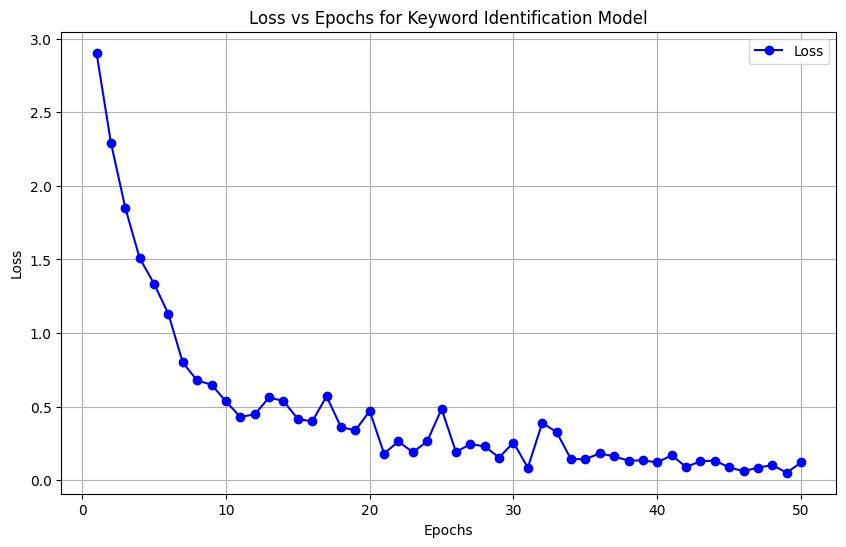

In [ ]:
import matplotlib.pyplot as plt

# Loss values from the output
loss_values = [
    2.9047969471324575, 2.500037605112249, 2.2943883592432197, 1.994692780754783, 1.8516032587398181,
    1.6091922304847024, 1.5087514898993752, 1.3198473020033403, 1.3356628634712913, 1.2404274181886152,
    1.12906583330848, 0.9313307783820413, 0.7996221564032815, 0.7259544946930625, 0.6772006154060364,
    0.7250295173038136, 0.6491497159004211, 0.6579638855023817, 0.5350113673643633, 0.5068892213431272,
    0.4297074567187916, 0.512621822682294, 0.4470094103704799, 0.500509503212842, 0.5615931329402056,
    0.4037983458150517, 0.5381479358131235, 0.5058130757375197, 0.41568859056992963, 0.4139075360514901,
    0.398953608491204, 0.5108778232877905, 0.5691806416619908, 0.385590134696527, 0.3605476929382844,
    0.3320818380876021, 0.33825700797817926, 0.26229977336796845, 0.4697189053351229, 0.16096376424485986,
    0.18053892932154916, 0.2291429110548713, 0.2630554275079207, 0.21149116415869107, 0.18926612152294678,
    0.2412082620642402, 0.2640788020058112, 0.3273940005085685, 0.48424664613875473, 0.36664945022626355,
    0.19128134914419867, 0.3271290964700959, 0.24501573091203516, 0.20509572598067197, 0.22963875328952615,
    0.16114453395659273, 0.1535389179533178, 0.17065582492134787, 0.2555632462555712, 0.1101612618023699,
    0.08458407460288568, 0.14176166853444142, 0.38944845070893114, 0.17730947651646353, 0.3261828822168437,
    0.18828061358495193, 0.1424707601016218, 0.14429915154522116, 0.1427430317483165, 0.16203069822354751,
    0.18139064159582963, 0.45254735072905367, 0.16114688393744556, 0.1989350342615084, 0.13264380429278722,
    0.20348827744072134, 0.13396081057461826, 0.1222954321313988, 0.12032860585234383, 0.17487666654315862,
    0.1689921184019609, 0.21034326776862144, 0.09003213454376567, 0.07898339561440727, 0.1274014679207043,
    0.0719844363629818, 0.13330195082182233, 0.06239880469035019, 0.0866703177717599, 0.042428094216368416,
    0.060846924273805184, 0.09236280510032718, 0.08463747596198862, 0.09841265173798258, 0.10273807334967634,
    0.05004731768911535, 0.0503607118840922, 0.10431302271106026, 0.12006737596609375, 0.2045869683338837
]

# take 1 skip 1 in loss_values
loss_values = loss_values[::2]

epochs = list(range(1, 51))

# Plotting the loss vs epoch graph
plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss')
plt.title('Loss vs Epochs for Keyword Identification Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


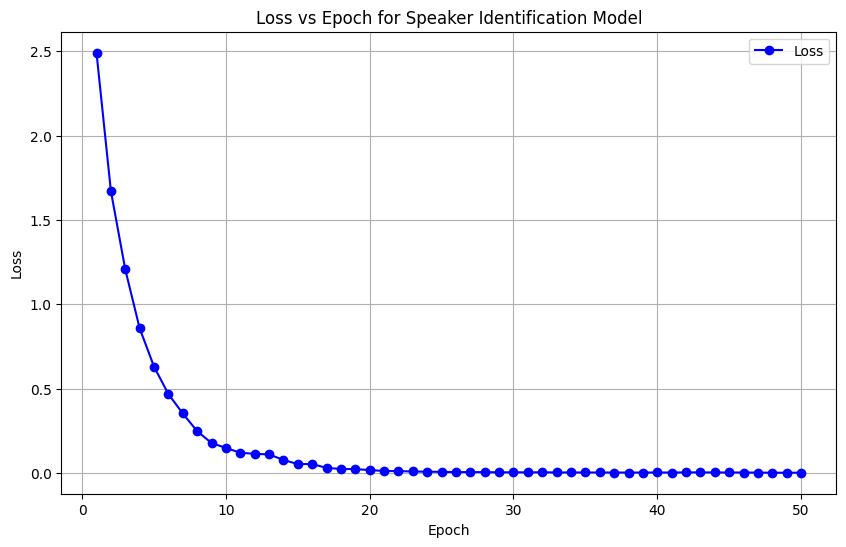

In [ ]:
import matplotlib.pyplot as plt

# Sample data for loss values and epochs (you can replace these with your actual data)
epochs = list(range(1, 51))  # Epochs from 1 to 50
losses = [
    2.491861128807068, 1.6721124410629273, 1.2071792125701903, 0.858307158946991,
    0.6306794047355652, 0.46794305443763734, 0.3531427562236786, 0.24792567938566207,
    0.1779066413640976, 0.14860645681619644, 0.12026567459106445, 0.11367635875940323,
    0.11051531881093979, 0.07758407481014729, 0.05302317515015602, 0.05322855841368437,
    0.03027181699872017, 0.024257092084735633, 0.022938505560159684, 0.017646338511258363,
    0.012180798780173063, 0.011162297381088138, 0.009129412611946464, 0.007702329568564892,
    0.007058338820934295, 0.005543177062645554, 0.005511565716005862, 0.005171623337082565,
    0.00418709956575185, 0.004242468299344182, 0.0041026939172297714, 0.004345783893950283,
    0.0034532070625573398, 0.0033862596144899728, 0.003235292749013752, 0.003191823931410909,
    0.002892016642726958, 0.0028861052240245046, 0.0027230851585045455, 0.003115734877064824,
    0.002897963719442487, 0.0038800000795163212, 0.0037274490343406795, 0.0033873544656671585,
    0.003270754066761583, 0.002961874078027904, 0.0025441149482503533, 0.0019562540110200644,
    0.0017492494080215693, 0.0018440000945702194
]

# Plotting the loss vs epoch graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Loss vs Epoch for Speaker Identification Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
